[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sachdevkartik/GSoC-2022/blob/main/test2_inference.ipynb)


# __Inferring the trained model of **Task V** Convolutional Visual Transformer (CvT)__


# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies. The cell also clone the solution repo as it contains a custom file for Convolutional Vision Transformers (CvT). 

In [1]:
# !pip install  split-folders \
#               torchinfo \
#               einops \
#               e2cnn
# !pip install --upgrade --no-cache-dir gdown

In [2]:
# # run in the case of Colab only
# %%bash
# set -m
# git clone https://github.com/sachdevkartik/GSoC-2022.git
# mv GSoC-2022/* . 
# rm -rf GSoC-2022

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [3]:
# %%bash
# bash setup.bash

# __Essential imports__

In [4]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from torchinfo import summary
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix

from cvt import CvT

## __Make required folders for data and models__

In [5]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
A set of simulated strong gravitational lensing images with and without substructure. 

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With substructure | 5000 |
| 2. | Without substructure | 5000 |

In [6]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


## __Extract data__
Check if the compressed data file is already extracted else extract data, and create the train-test split (0.9:0.1). <br>

The data folder looks like: 

```bash
    lenses
    ├── train
    │   ├── no_sub
    │   └── sub
    └── val
        ├── no_sub
        └── sub
```

In [7]:
# initialize the data directory name  
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracted folder exists


In [8]:
print(f"Torch: {torch.__version__}")

Torch: 1.6.0


## __Set Config and Hyperparameters__

In [9]:
# Data setting
n_classes = 2               # number of classes to be classified
image_size = 129              # image size (224x224)

# Training parameters
batch_size = 64             # batch size
epochs = 40                 # number of epochs
lr = 1e-4                   # learning rate

# optimizer parameters
weight_decay = 1e-7         # L2 penalty
gamma = 0.5                 # factor by which to decrease learning
step_size_opt = 5           # interval to apply optimizer scheduler 
use_lr_schedule = False     # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # Using CUDA
cuda_idx = 0                # idx of CUDA device to be used

In [10]:
def seed_everything(seed):
    """Fixing various seeds

    Args:
        seed (int): any seed number

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## __Select CUDA device for training__

In [11]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """

    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [12]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


## __Transformations__ 

Transformers generally require a larger amount of data, thus, to compensate for lack of data, I rely on extensive data augmentation. Multiple transformation strategies were used and tested. <br>
Winning strategy:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
5. Random Affine in both orientation (20 $^{\circ}$ - 80 $^{\circ}$), translation (0.1 - 0.2) and scaling (0.4-0.95)
6. Random Perspective with distortion scale=0.3 and probability = 0.1
7. Resized to $224 \times 224$.
8. Converting to grayscale
9. Converting PIL image to tensor

Some parts of transformation were also refered from the existing implementation with equivariant networks.

__Tested Strategies__: <br>
Randomly select a predefined combination of transformation from a list e.g. transform1 & transform2 in order to have variation in training data. <br>
```RandAugment``` was also tested but did not give good results as it changed color statistics which are not present in test data. <br>
Also, no alteration in color setting was made as the data is more or less similar with respect to color statistics. 

In [13]:
# images are padded to have shape 129x129.
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts
# upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [14]:
def get_transform_train():

    random_transform = []

    transform1 = transforms.Compose([
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        RandomPerspective(distortion_scale=0.3, p=0.1),
        ])
  
    transform2 = transforms.Compose([
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        ])

    transform_list = [transform1, transform2]

    transform_prob = 1.0 / len(transform_list)
    for transform in transform_list:
        random_transform.append( transforms.RandomApply([transform], transform_prob) )


    transform_train = Compose([
        transforms.RandomCrop(128),
        pad,
        resize1,
        RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
        RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
        RandomPerspective(distortion_scale=0.3, p=0.1),
        # transforms.RandomApply(random_transform, 0.9999),
        Resize((224, 224)),
        togray,
        totensor,
    ])

    transform_train_eq = transforms.Compose([
        transforms.RandomCrop(128),
        pad,
        resize1,
        RandomRotation(180, resample=Image.BILINEAR, expand=False),
        resize2,
        togray,
        totensor,
    ])
    
    return transform_train_eq

transform_test = Compose([
    transforms.RandomCrop(128),
    pad,
    resize2,
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [15]:
class CustomDataset(Dataset):
    """Create custom dataset for the given data

    """

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [16]:
trainset = CustomDataset(data_dir,'train',transform=get_transform_train())
valset = CustomDataset(data_dir,'val',transform=transform_test)

## __Dataloader__ 
Loading train and test data with shuffle and given batch size

In [17]:
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

## __Visualize train image samples__

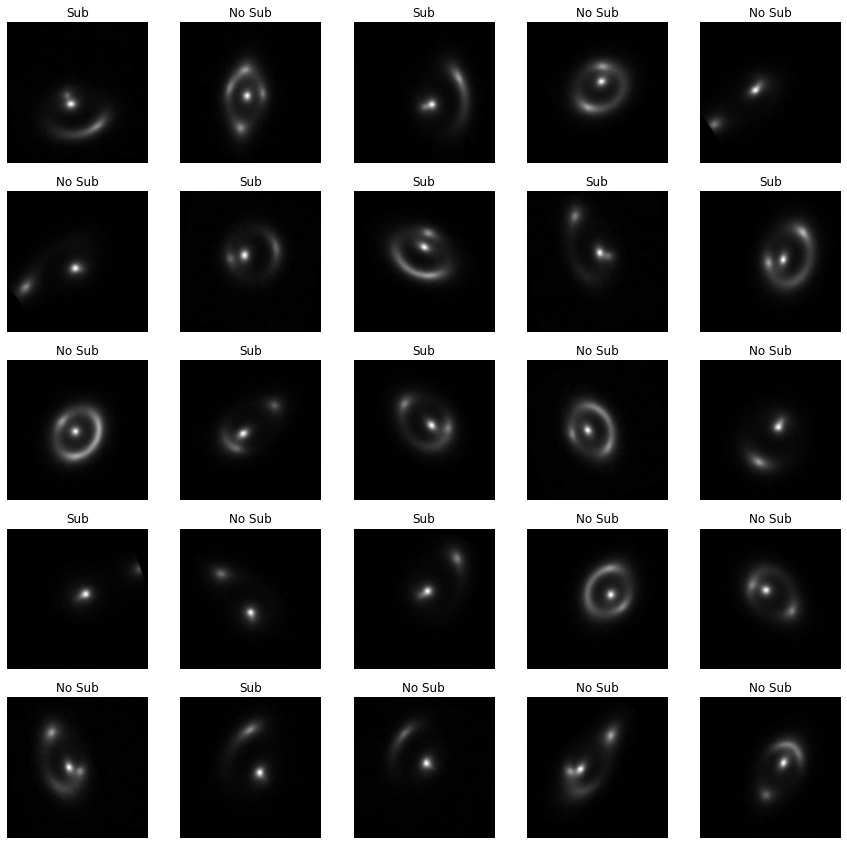

In [18]:
labels_map = {0: 'No Sub',1:'Sub'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    im = img.squeeze()
    plt.imshow(im, cmap='gray')
plt.show()

In [19]:
# get the number of samples in train and test set
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 9000
Val Data: 1000


## __Loading trained Model__

In [20]:
# Lightweight CvT model
from cvt import CvT, EqCvT
best_model = EqCvT(
    channels = 1,
    num_classes = 2,
    s1_emb_dim = 32,       # stage 1 - (same as above)
    s1_emb_kernel = 3,
    s1_emb_stride = 2,
    s1_proj_kernel = 3,
    s1_kv_proj_stride = 2,
    s1_heads = 3,
    s1_depth = 2,
    s1_mlp_mult = 2,
    mlp_last = 64,
    dropout = 0.1,
    sym_group = 'Circular', 
    N = 4,
    image_size=image_size,
    e2cc_mult_1 = 10,
).to(device)

# best_model.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(best_model))
print(best_model)

MODEL_PATH = 'model/e2cnn_vit_2022-04-04-23-41-30.pt'
best_model.load_state_dict(torch.load(MODEL_PATH))


/home/kartik/anaconda3/envs/dlvr/lib/python3.8/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  full_mask[mask] = norms.to(torch.uint8)


64810
EqCvT(
  (block1): SequentialModule(
    (0): MaskModule()
    (1): R2Conv([4-Rotations: {irrep_0}], [4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], kernel_size=7, stride=1, padding=1, bias=False)
    (2): InnerBatchNorm([4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True, type=[4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}])
  )
  (pool1): PointwiseAvgPoolAntialiased()
  (gpool): GroupPooling([4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}])
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LayerNorm()
      (2): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
 

<All keys matched successfully>

## __Evaluation__

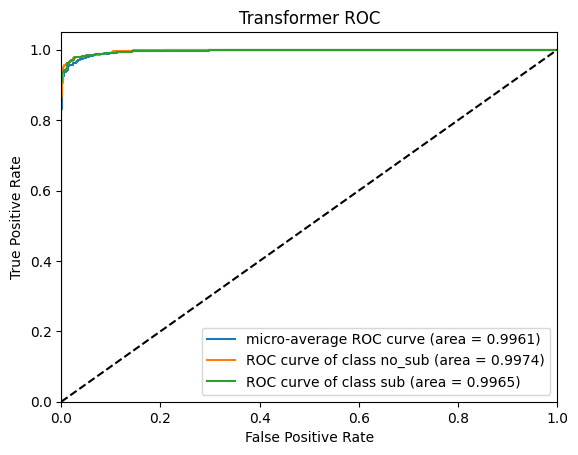

In [21]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(n_classes,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in valset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC')
plt.legend(loc="lower right")
plt.show()

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


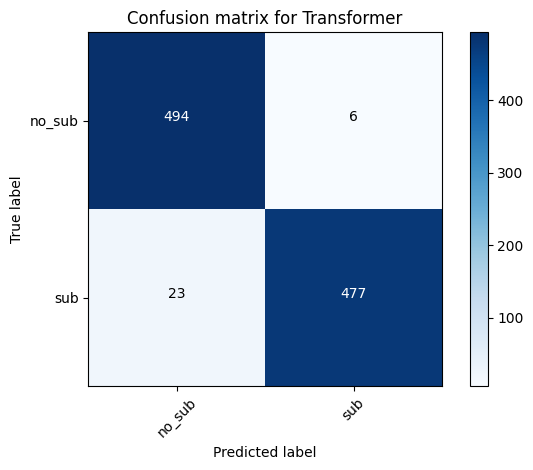

In [23]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1]],title='Confusion matrix for Transformer')

# __Cite__

Inspired from: <br> <br> 
[CvT: Introducing Convolutions to Vision Transformers](https://arxiv.org/abs/2103.15808)


  ```
  @article{wu2021cvt,
    title={Cvt: Introducing convolutions to vision transformers},
    author={Wu, Haiping and Xiao, Bin and Codella, Noel and Liu, Mengchen and Dai, Xiyang and Yuan, Lu and Zhang, Lei},
    journal={arXiv preprint arXiv:2103.15808},
    year={2021}
  }
  ```
[General E(2)-Equivariant Steerable CNNs](https://arxiv.org/abs/1911.08251)
 
```
@inproceedings{e2cnn,
    title={{General E(2)-Equivariant Steerable CNNs}},
    author={Weiler, Maurice and Cesa, Gabriele},
    booktitle={Conference on Neural Information Processing Systems (NeurIPS)},
    year={2019},
}
```

Apoorva Singh, Yurii Halychanskyi, Marcos Tidball, DeepLense, (2021), GitHub repository, https://github.com/ML4SCI/DeepLense
